https://www.kaggle.com/code/robikscube/working-with-video-in-python-youtube-tutorial/notebook

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob
import IPython.display as ipd
from tqdm.notebook import tqdm

import subprocess

Convert video file format 
mov to mp4 

In [2]:
input_file = '../dataset/videos/0000f77c-6257be58.mov'
subprocess.run([
    'ffmpeg',
    '-i',
    input_file,
    '-qscale',
    '0',
    '0000f77c-6257be58.mp4'
])

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

KeyboardInterrupt: 

#### Display in notebook

In [6]:
ipd.Video('0000f77c-6257be58.mp4', width=500)

#### Open video and read metadata

In [3]:
cap = cv2.VideoCapture('0000f77c-6257be58.mp4')

# frame count
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f'frame count: {frame_count}\n(width, height): ({frame_width}, {frame_height})\n frame rate: {frame_rate:0.2f}')

frame count: 1211.0
(width, height): (1280.0, 720.0)
 frame rate: 29.97


#### Pulling in images from video

In [8]:
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    # ax.axis('off')

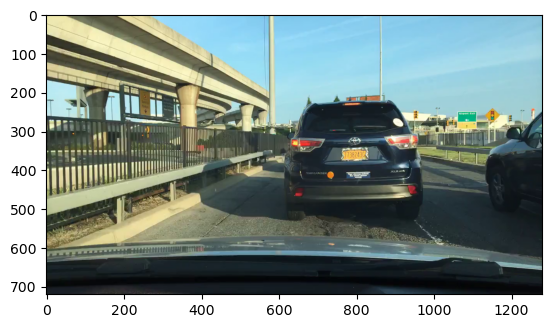

In [9]:
cap = cv2.VideoCapture('0000f77c-6257be58.mp4')

res, img = cap.read()

# show image with matplotlib
# plt.imshow(img)

# display_cv2_img(img)

cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cvt_img)

#### Release video capture object

In [10]:
cap.release()

#### Display multiple frames from the video

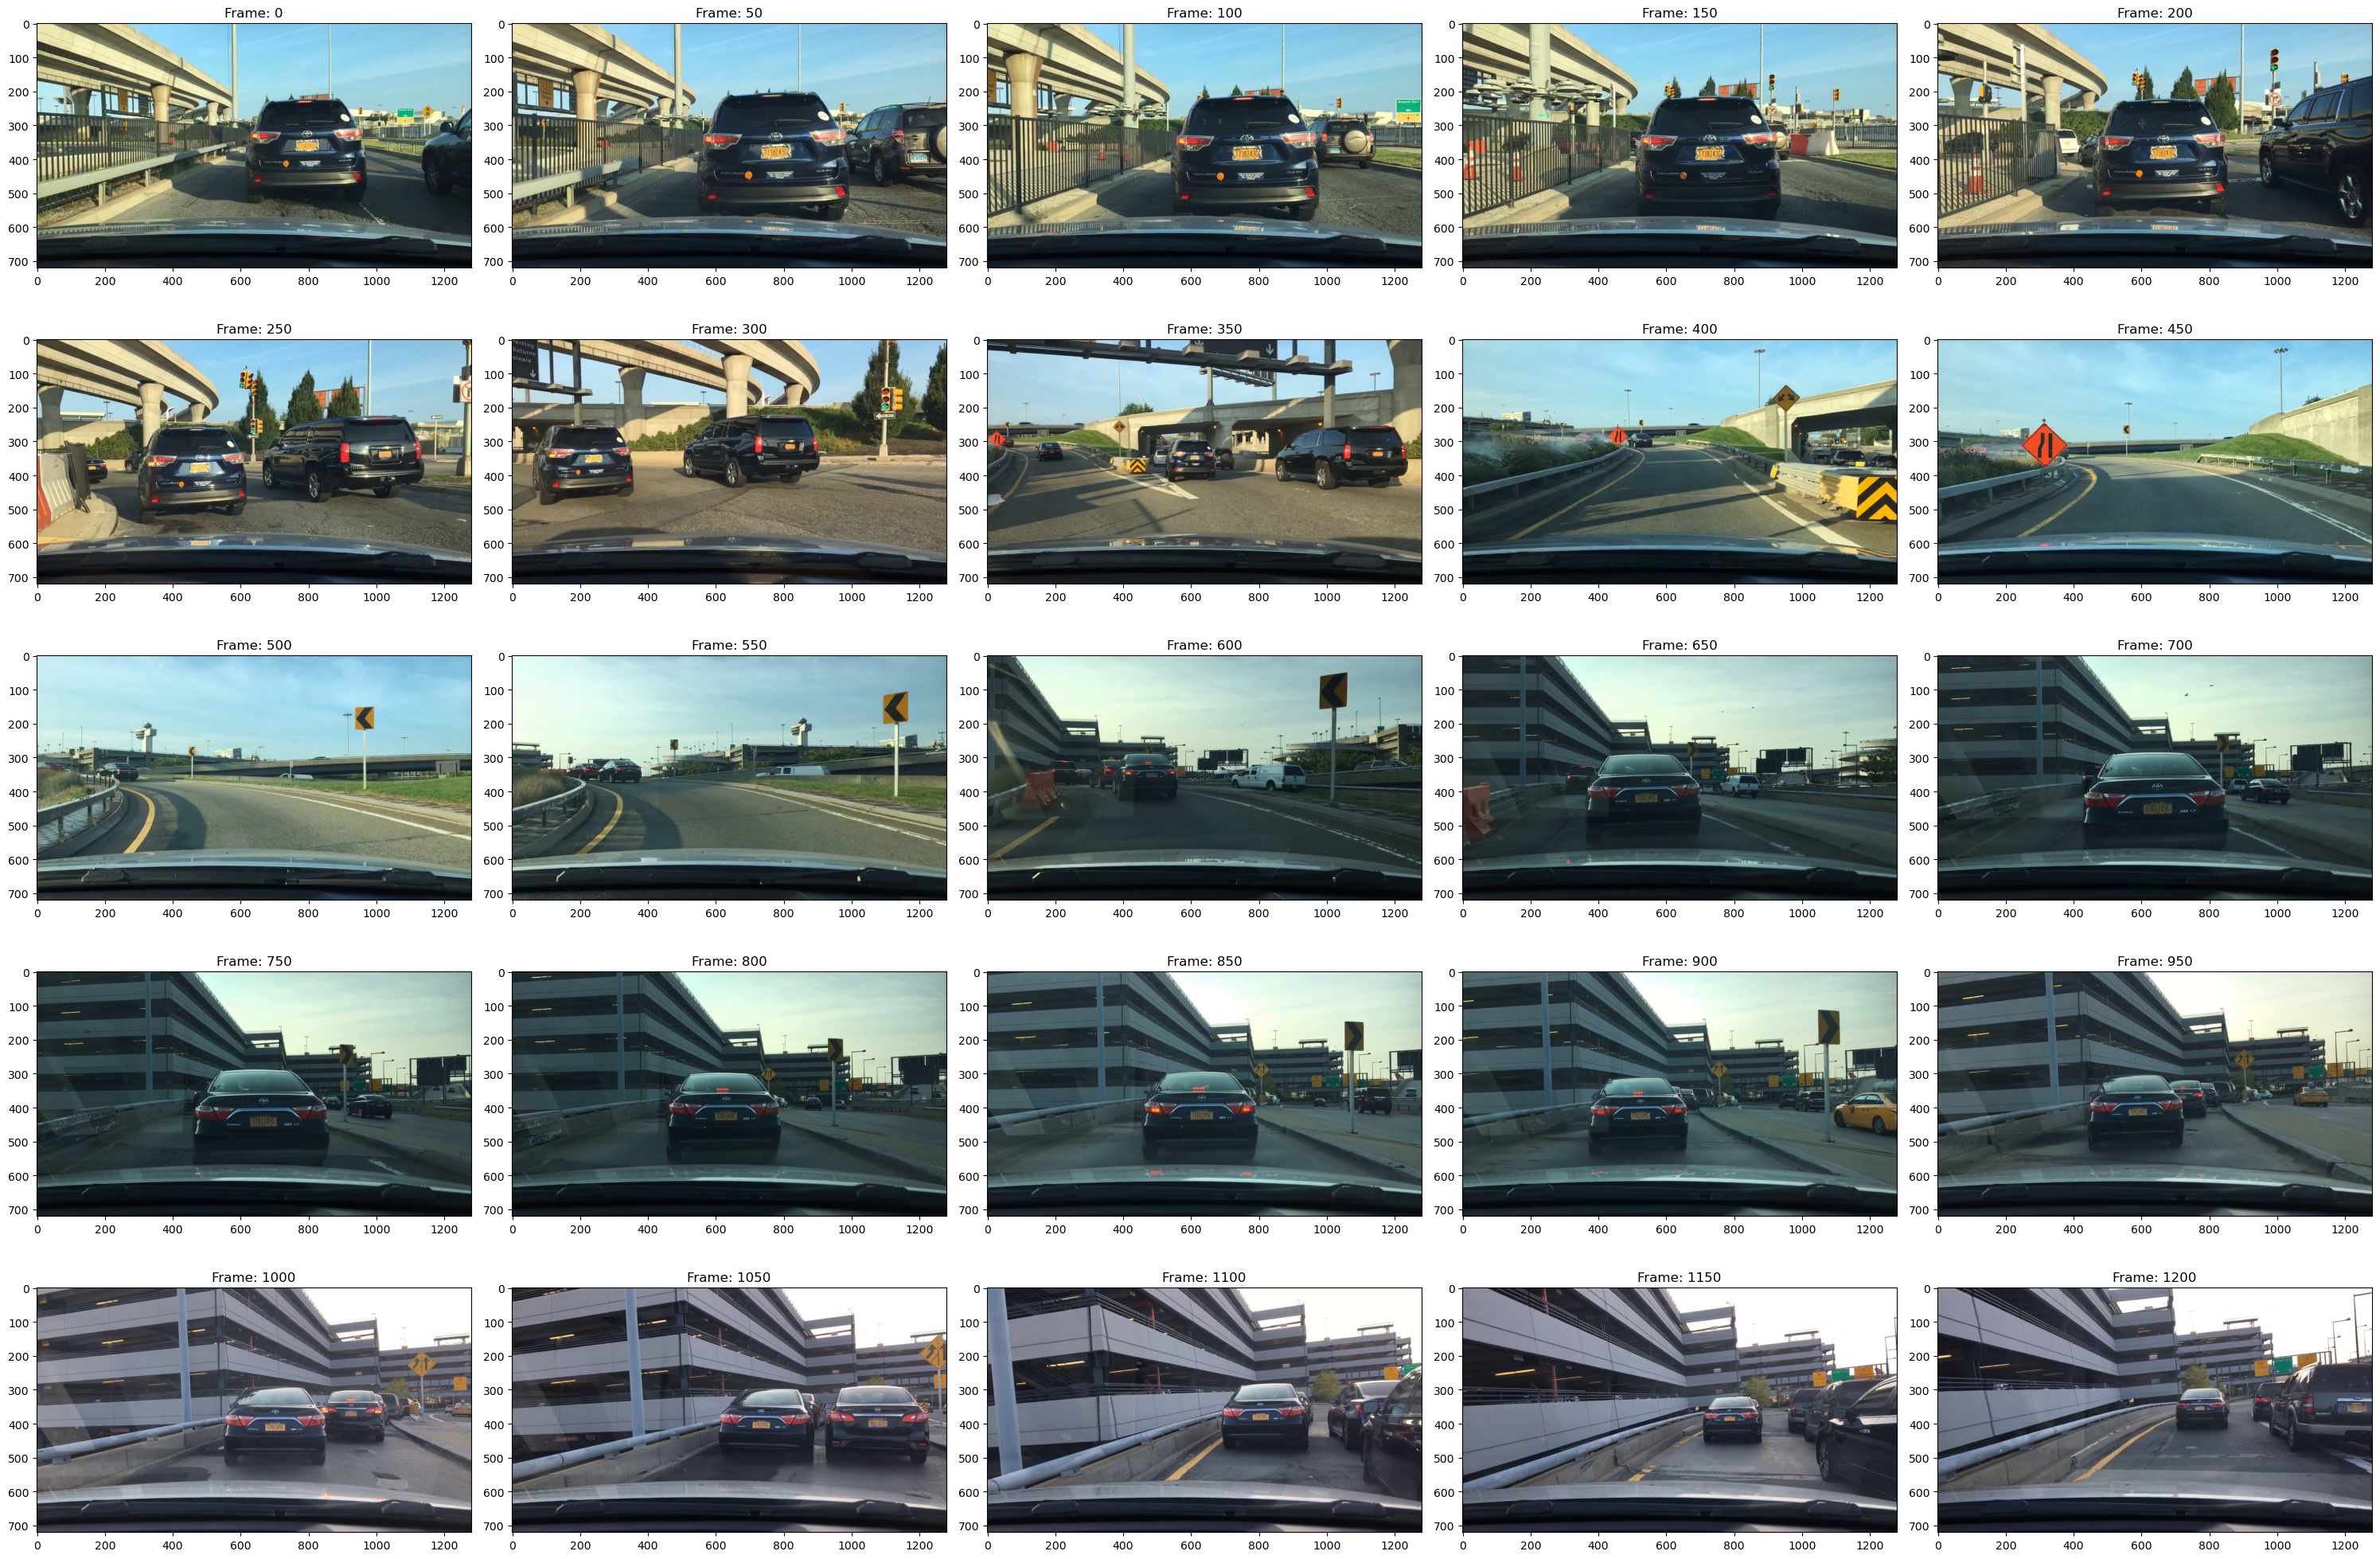

In [11]:
fig, axs = plt.subplots(5, 5, figsize=(30, 20))
axs = axs.flatten()

cap = cv2.VideoCapture('train-video-1.mp4')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0
for frame in range(n_frames):
    returns, image = cap.read()
    if returns == False:
        break
    
    # show 100s images
    if frame % 50 == 0:
        axs[img_idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[img_idx].set_title(f'Frame: {frame}')
        # axs[img_idx].axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()
cap.release()



#### Add annotations for video images

In [12]:
labels = pd.read_csv('mot_labels.csv')

video_labels = (
    labels.query('videoName == "0000f77c-6257be58"').reset_index(drop=True).copy()
)

video_labels['video_frame'] = (video_labels['frameIndex'] * 11.9).round().astype('int')

/tmp/ipykernel_17190/886232692.py:1: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv('mot_labels.csv')


In [13]:
video_labels['category'].value_counts()

category
car    1126
Name: count, dtype: int64

In [14]:
# pull frame 1035
cap = cv2.VideoCapture('0000f77c-6257be58.mp4')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0

for frame in range(n_frames):
    returns, img = cap.read()
    if returns == False:
        break
    if frame == 383:
        break
cap.release()

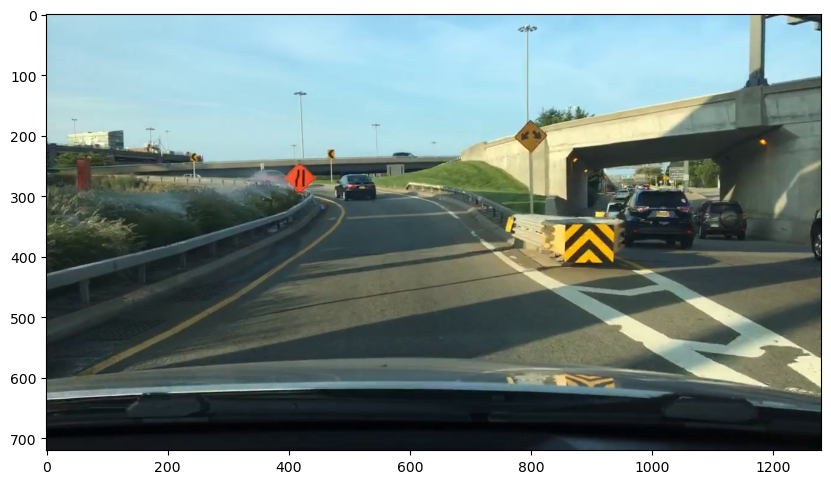

In [15]:
display_cv2_img(img)

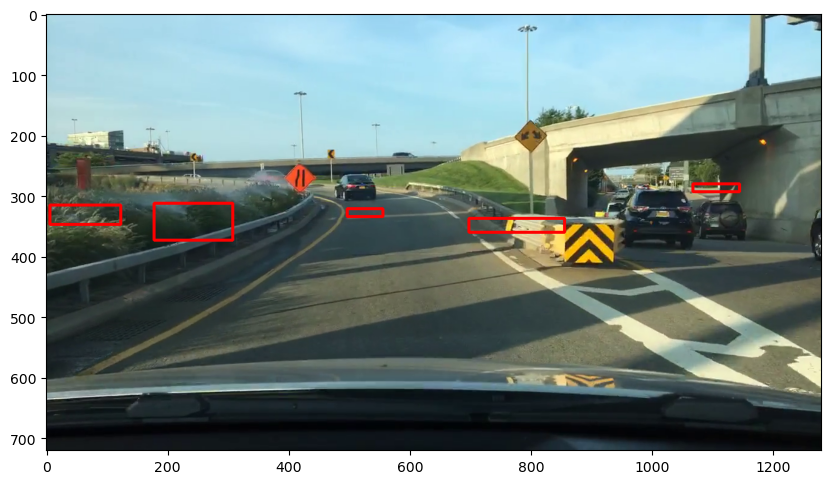

In [16]:
frame_labels = video_labels.query('video_frame == 1035')

for i, d in frame_labels.iterrows():
    pt1 = int(d['box2d.x1']), int(d['box2d.y1'])
    pt2 = int(d['box2d.x2']), int(d['box2d.y2'])
    cv2.rectangle(img, pt1, pt2, (0, 0, 255), 3)

display_cv2_img(img)


#### Label and output annotated video

In [28]:
def add_annotations(img, frame, video_labels):
    max_frame = video_labels.query('video_frame <= @frame')
    frame_labels = video_labels.query('video_frame == @max_frame')

    for i, d in frame_labels.iterrows():
        pt1 = int(d['box2d.x1']), int(d['box2d.y1'])
        pt2 = int(d['box2d.x2']), int(d['box2d.y2'])
        
        img = cv2.rectangle(img, pt1, pt2, (120, 140, 204), 3)
    
    return img


#### Output new video

In [31]:
VIDEO_CODEC = 'X264'
fps = frame_rate
width = 1280
height = 720
fourcc = cv2.VideoWriter.fourcc(*'MJPG')

out = cv2.VideoWriter(
    'output_test.avi',
    fourcc,
    fps,
    (width, height),
    True
)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

cap = cv2.VideoCapture('0000f77c-6257be58.mp4')

for frame in tqdm(range(n_frames)):
    ret, img = cap.read()
    if ret == False:
        break
    img = add_annotations(img, frame, video_labels)
    out.write(img)

out.release()
cap.release()

  0%|          | 0/1211 [00:00<?, ?it/s]

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.